In [73]:
# f = (f' - B - d * t) / med (f' - b - d * t)
# D = D' - B
# B = B' + Berr

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [75]:
# parameters
# gain electrons per adu
g = 3.6
# dimension 
row = 2048
column = 2048
# bias levels 
# real bias level count per pixel 
bias_real_level = 300
# the systematic readout error on the bias
readnoise = 5
# assumed bias level 
# float up to factor 
factor = 2 
bias_meas_array = np.linspace(bias_real_level/factor, bias_real_level*factor)
# bias_meas_array = [bias_real_level]
# dark
# dark current elec per sec
d = 0.05
# time dark exposure
td = 60
# flat counts per pixel 
f = 10000
# time flat exposure 
tf_array = np.linspace(3, 120)

In [76]:
para_dict = {
    'bias_level': 300,
    'row': 2048,
    'column': 2048,
    'g': 3.6,
    'readnoise': 5,
    'd': 0.05,
    'td': 60,
    'f': 10000,
    'tf_array': np.linspace(3, 120)   
}

In [77]:
# function making a bias based on a given bias input
# normal distributed 
# output: 2d bias level in counts per pixel 
def makeBias(bias_level,size=(row,column),readnoise=5,debug=False):
    bias = np.random.normal(bias_level, readnoise, size)
    return bias

In [78]:
def makeDarkCounts(td=60,d=0.05,size=(row,column),debug=False,g=3.6):
    dark_counts = np.random.poisson(d*td, size) / g 
    return dark_counts

In [79]:
# dark function based on a given bias input
# possion distributed
# output: 2d dark current in counts per sec per pixel 
def makeDark(bias_level,td=60,d=0.05,size=(row,column),debug=False,g=3.6):
    dark = makeDarkCounts(td=td,d=d,size=size,debug=debug,g=g) + \
                              makeBias(bias_level,size=size,debug=debug)
    return dark    

In [80]:
# flat function 
# possion distributed 
# output: 2d raw flat level in counts per pixel 
def makeRawFlat(bias_level,debug=False,g=3.6,
                f=15000,size=(row,column)):
    flat = makeBias(bias_level) + np.random.poisson(f, size)
    return flat

In [81]:
# calibrated flat function 
# output: 2d calibrated flat level in counts per pixel 
def makeCaliFlat(bias, dark, raw_flat, tf=3, td=60, debug = False):
    caliFlat = (raw_flat - dark / td * tf - bias) / np.median(raw_flat - dark / td * tf - bias)
    return caliFlat 

In [86]:
bias_real = makeBias(bias_real_level)
dark_real = makeDark(bias_real_level)
flat_raw = makeRawFlat(bias_real_level)

bias_meas = makeBias(600)
dark_meas = makeDark(600)
flat_meas = makeRawFlat(600)

flat_real = makeCaliFlat(bias_real, dark_real, flat_raw, 120)
flat_fake = makeCaliFlat(bias_meas, dark_meas, flat_meas, 120)

display(flat_real)
display(flat_fake)

p = (flat_fake - flat_real) / flat_real
display(p)

array([[0.99366475, 0.98592961, 0.99694017, ..., 0.99708539, 1.01134062,
        1.00182432],
       [0.99792557, 1.00321685, 1.0081114 , ..., 1.00455611, 1.00733177,
        0.99066363],
       [1.0001062 , 0.99872791, 0.99624666, ..., 1.00950646, 0.99289976,
        1.00195445],
       ...,
       [1.00048651, 0.98870488, 1.01465238, ..., 1.00943254, 1.00168053,
        0.99554681],
       [1.00065689, 0.9958638 , 1.00706035, ..., 1.00395654, 1.0015149 ,
        0.98697261],
       [0.98367028, 0.99993319, 1.01129685, ..., 1.00342385, 0.98572056,
        0.97919839]])

array([[0.99762493, 0.99020345, 0.99889268, ..., 0.99395608, 1.00053792,
        1.01257547],
       [0.99375698, 0.98941185, 1.00631922, ..., 1.01384582, 0.99948105,
        0.9918523 ],
       [1.00723696, 1.00830628, 0.9912916 , ..., 1.0217644 , 1.00942611,
        0.99542352],
       ...,
       [1.0087556 , 1.00190736, 0.99143507, ..., 1.00190519, 1.00163902,
        0.98867999],
       [1.00177357, 0.9997558 , 1.0111896 , ..., 1.01006491, 0.97971713,
        1.00916089],
       [1.00085691, 1.00077698, 1.00381212, ..., 1.00063298, 0.98410703,
        0.98797356]])

array([[ 3.98542997e-03,  4.33483780e-03,  1.95850333e-03, ...,
        -3.13846050e-03, -1.06815689e-02,  1.07315695e-02],
       [-4.17726378e-03, -1.37607340e-02, -1.77776314e-03, ...,
         9.24756947e-03, -7.79358191e-03,  1.19986464e-03],
       [ 7.13000439e-03,  9.59057146e-03, -4.97372101e-03, ...,
         1.21425114e-02,  1.66445321e-02, -6.51818782e-03],
       ...,
       [ 8.26507505e-03,  1.33533095e-02, -2.28820309e-02, ...,
        -7.45701073e-03, -4.14439898e-05, -6.89753245e-03],
       [ 1.11594032e-03,  3.90816403e-03,  4.10030603e-03, ...,
         6.08429433e-03, -2.17647954e-02,  2.24811433e-02],
       [ 1.74719498e-02,  8.43849077e-04, -7.40112178e-03, ...,
        -2.78134647e-03, -1.63690103e-03,  8.96158897e-03]])

In [65]:
def systematic_deviation(bias_level, time = 1, tf_array = tf_array, debug = False):
    # see the error with same bias 
    percent_change_in_flat_array = []
    percent_change_in_flat_array_std = []
    tf_plot_array = []
    for tf in tf_array:
        percent_change_in_flat_array_storage = []
        for i in range(time):
            bias_real_1 = makeBias(bias_level)
            dark_real_1 = makeDark(bias_level)
            flat_raw_1 = makeRawFlat(bias_level, tf)
            flat_real_1 = makeCaliFlat(bias_real_1, dark_real_1, flat_raw_1, tf)
            bias_real = makeBias(bias_level)
            dark_real = makeDark(bias_level)
            flat_raw = makeRawFlat(bias_level, tf)
            flat_real = makeCaliFlat(bias_real, dark_real, flat_raw, tf)
            deltaf = np.abs(flat_real - flat_real_1)
            # flat percent change in a mean form 
            percent_change_in_flat = np.mean(deltaf / flat_real_1 * 100)
            percent_change_in_flat_array_storage.append(percent_change_in_flat)
        mean = np.mean(percent_change_in_flat_array_storage)
        std = np.std(percent_change_in_flat_array_storage)
        percent_change_in_flat_array.append(mean)
        percent_change_in_flat_array_std.append(std)
        tf_plot_array.append(tf)
    plt.scatter(tf_plot_array, percent_change_in_flat_array)
    plt.errorbar(tf_plot_array, percent_change_in_flat_array,
                yerr = percent_change_in_flat_array_std,
                fmt ='o')
    plt.xlabel('TF changes')
    plt.ylabel('Flat changes perc')
    plt.show()
    

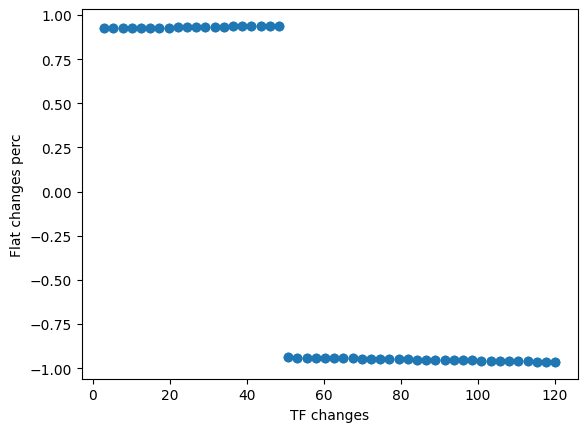

In [66]:
systematic_deviation(bias_real_level)

In [67]:
def func(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y

In [68]:
def propagation(bias_real_level = bias_real_level, bias_meas_array = bias_meas_array, tf_array = tf_array, debug = False):
    # prop storage array
    percent_change_in_bias_array = []
    percent_change_in_flat_array = []
    tf_plot_array = []

    # making the real bias, dark, and flat
    bias_real = makeBias(bias_real_level)
    dark_real = makeDark(bias_real_level)
    flat_raw = makeRawFlat(bias_real_level)
    flat_real_dict = {}
    for tf in tf_array:
        flat_real = makeCaliFlat(bias_real, dark_real, flat_raw, tf)
        flat_real_dict[tf] = flat_real
        
    if debug:
        display(flat_real_dict[tf_array[1]])
        
    # prop 
    for b in bias_meas_array:
        # measured bias 2d array
        bias_meas = makeBias(b)
        # bias displacement
        deltab = bias_meas - bias_real
        # bias percent change mean
        percent_change_in_bias = np.mean(deltab / bias_real * 100)
        # measured dark 
        dark_meas = makeDark(b)
        # measured raw flat in a 2d array
        flat_raw = makeRawFlat(b)
        for tf in tf_array:
            # real calibrated flat in a 2d array 
            flat_real = flat_real_dict[tf]
            # measured flat in a 2d array
            flat_meas = makeCaliFlat(bias_meas, dark_meas, flat_raw, tf)
            # flat displacement in a 2d 
            deltaf = np.abs(flat_meas - flat_real)
            # flat percent change in a mean form 
            percent_change_in_flat = np.mean(deltaf / flat_real * 100)
            percent_change_in_bias_array.append(percent_change_in_bias)
            percent_change_in_flat_array.append(percent_change_in_flat)
            tf_plot_array.append(tf)
            
    if debug:
        ax = plt.axes(projection='3d')
        # Adding data to our axes, 's=40' is to increase point size by 40
        ax.scatter3D(percent_change_in_bias_array, tf_plot_array, percent_change_in_flat_array, s=1) 
        # Labelling your axes
        ax.set_xlabel('Percent change in Bias')
        ax.set_ylabel('Time Flat Exposure')
        ax.set_zlabel('Percent change in Flat')
        
    
    # Perform curve fitting
    popt, pcov = curve_fit(func, (percent_change_in_bias_array, tf_plot_array), percent_change_in_flat_array)
    
    if debug: 
            
        X, Y = np.meshgrid(percent_change_in_bias_array, tf_plot_array)
        pred_flat_change = func((X, Y), *popt)
        
        ax = plt.axes(projection='3d')
        # Adding data to our axes, 's=40' is to increase point size by 40
        ax.scatter3D(percent_change_in_bias_array, tf_plot_array, percent_change_in_flat_array, s=1) 
        ax.plot_surface(X, Y, pred_flat_change, color='red', alpha=0.5)
        # Labelling your axes
        ax.set_xlabel('Percent change in Bias')
        ax.set_ylabel('Time Flat Exposure')
        ax.set_zlabel('Percent change in Flat')
        
    return popt, pcov
            
    

In [69]:
popt, pcov = propagation(debug = True)

array([[1.11363136, 1.12493104, 1.1158184 , ..., 1.10695253, 1.11364152,
        1.12172693],
       [1.12542907, 1.12108952, 1.11590703, ..., 1.13174295, 1.12719677,
        1.12148249],
       [1.11347917, 1.11245705, 1.12925031, ..., 1.1287046 , 1.11836985,
        1.12682362],
       ...,
       [1.12157171, 1.1223628 , 1.11542485, ..., 1.10289941, 1.11994544,
        1.11268242],
       [1.11737665, 1.11852562, 1.1204142 , ..., 1.12884762, 1.11771141,
        1.13099172],
       [1.11705894, 1.1176799 , 1.1310264 , ..., 1.11577316, 1.12160132,
        1.12597598]])

KeyboardInterrupt: 